In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.8 MB/s 


In [ ]:
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import json
from matplotlib.colors import to_rgb

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm
import random

dict = {'classes' : ['Building','Land (unpaved area)','Road','Vegetation', 'Water','Unlabeled'],
        'colors' : ['#3C1098', '#8429F6', '#6EC1E4', '#FEDD3A', '#E2A929', '#9B9B9B']}

patch_size = 256

def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for i,col in enumerate(dict['colors']):
        color = np.array([255 * x for x in to_rgb(col)]).astype('uint8')
        ref[np.all(label == color,axis=-1)] = i
    return ref

def patchify(img):
    m,n,b = img.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(img[i:i+patch_size,j:j+patch_size,:])
    return crops

def patchify_lab(label):
    m,n = label.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(label[i:i+patch_size,j:j+patch_size])
    return crops


def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

folder = r"Semantic-segmentation-dataset"
tiles = os.listdir(folder)
train_set = []
train_lab = []
test_set = []
test_lab = []
for tile in tiles:
    if os.path.isdir(os.path.join(folder,tile)):
        files = os.listdir(os.path.join(folder,tile,'images'))
        for file in files:
            img = imageio.imread(os.path.join(folder,tile,'images',file))/255
            img = patchify(img)
            label = imageio.imread(os.path.join(folder,tile,'masks',file[:-3] + 'png'))
            label = labelize(label)
            label = patchify_lab(label)

            if file == 'image_part_009.jpg':
                test_set = test_set + img
                test_lab = test_lab + label
            else:
                train_set = train_set + img
                train_lab = train_lab + label
                
train_set = np.array(train_set)  
test_set = np.array(test_set)  
train_lab = np.array(train_lab) 
n_classes = len(np.unique(train_lab)) 
train_lab = to_categorical(train_lab, num_classes=n_classes)
test_lab = np.array(test_lab)  
test_lab = to_categorical(test_lab, num_classes=n_classes)
print(train_set.shape)
print(test_set.shape)
print(train_lab.shape)
print(test_lab.shape)
X_train, X_test, y_train, y_test = train_test_split(train_set, train_lab, test_size = 0.20, random_state = 42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

Segmentation Models: using `keras` framework.


<ipython-input-3-84bd52d01783>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ref[np.all(label == color,axis=-1)] = i


(1160, 256, 256, 3)
(145, 256, 256, 3)
(1160, 256, 256, 6)
(145, 256, 256, 6)
X_train shape:  (928, 256, 256, 3)
y_train shape:  (928, 256, 256, 6)
X_test shape:  (232, 256, 256, 3)
y_test shape:  (232, 256, 256, 6)


In [ ]:
!pip install keras-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 7.1 MB/s 
     |████████████████████████████████| 753 kB 59.9 MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29071 sha256=9fb2ca049975fad8cf0dfd7e444361810984b7f0d6ffe434bf77c870ceb76976
  Stored in directory: /root/.cache/pip/wheels/8f/86/73/3dc66376905add0f57142bdd6e2117db5d4aa6340e34d039c7
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0


In [ ]:
from subprocess import check_output

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard


class_names = ['Building','Land (unpaved area)','Road','Vegetation', 'Water','Unlabeled']
image_rows = 256
image_cols = 256
batch_size = 4096
image_shape = (image_rows,image_cols,3) 

def cnn_model(n_classes, input_shape):
  img_input = Input(shape=input_shape)
  # encoder layer 1
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
  conv1 = Dropout(0.2)(conv1)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  # add an additional layer to do the same encoding as layer 1
  conv1_addition = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  conv1_addition = Dropout(0.2)(conv1_addition)
  conv1_addition = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_addition)
  pool1_addition = MaxPooling2D((2, 2))(conv1_addition)
  # encoder layer 2
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1_addition)
  conv2 = Dropout(0.2)(conv2)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  # decoder layer 1
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Dropout(0.2)(conv3)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  # concate the intermediate encoder conv2 outputs with the intermediate decoder conv3 outputs
  up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1) 

  # decoder layer 2
  conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
  conv4 = Dropout(0.2)(conv4)
  conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
  # concate the intermediate encoder conv1 outputs with the intermediate decoder conv4 outputs
  up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
  # decoder layer 3
  conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
  conv5 = Dropout(0.2)(conv5)
  conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
  # output layer
  out = Conv2D( n_classes, (1, 1) , activation='softmax', padding='same')(conv5)

  model = Model(inputs=[img_input], outputs=[out])
  return model



In [ ]:
model = cnn_model(6, image_shape)
model.compile(loss =sm.losses.DiceLoss(), optimizer='adam',metrics =['accuracy', jaccard_coef])

In [ ]:

history = model.fit(
                X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=True 
)


Epoch 1/5
116/116 [==============================] - 1689s 15s/step - loss: 0.6968 - accuracy: 0.5800 - jaccard_coef: 0.3964 - val_loss: 0.5610 - val_accuracy: 0.6933 - val_jaccard_coef: 0.5182
Epoch 2/5
116/116 [==============================] - 1681s 14s/step - loss: 0.5470 - accuracy: 0.7020 - jaccard_coef: 0.5425 - val_loss: 0.5202 - val_accuracy: 0.6932 - val_jaccard_coef: 0.5368
Epoch 3/5
116/116 [==============================] - 1678s 14s/step - loss: 0.4907 - accuracy: 0.7410 - jaccard_coef: 0.5920 - val_loss: 0.5052 - val_accuracy: 0.7019 - val_jaccard_coef: 0.5496
Epoch 4/5
116/116 [==============================] - 1678s 14s/step - loss: 0.4779 - accuracy: 0.7531 - jaccard_coef: 0.6086 - val_loss: 0.4616 - val_accuracy: 0.7453 - val_jaccard_coef: 0.6021
Epoch 5/5
116/116 [==============================] - 1689s 15s/step - loss: 0.4723 - accuracy: 0.7578 - jaccard_coef: 0.6151 - val_loss: 0.4572 - val_accuracy: 0.7487 - val_jaccard_coef: 0.6069


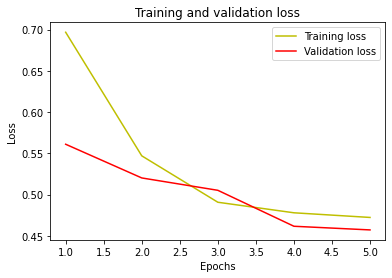

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

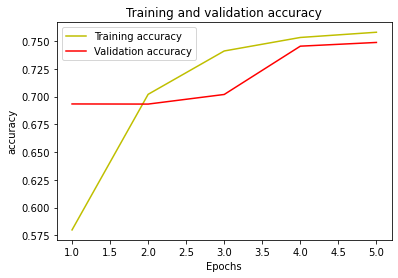

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

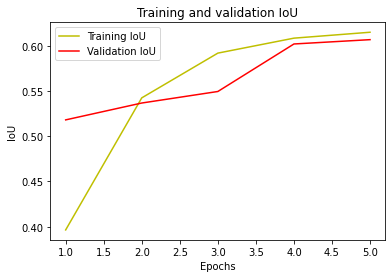

In [ ]:
acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
Jacc = jaccard_coef(y_test,y_pred)
print('IoU = {}'.format(Jacc))
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

8/8 [==============================] - 89s 11s/step
IoU = 0.5979156494140625


1/1 [==============================] - 0s 403ms/step


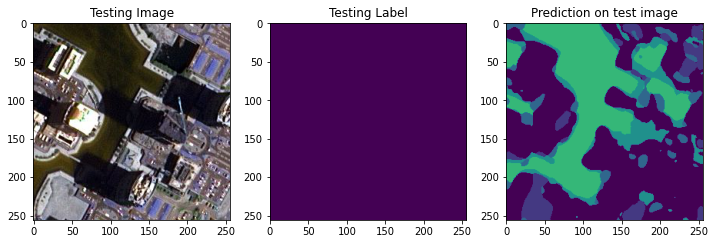

1/1 [==============================] - 0s 422ms/step


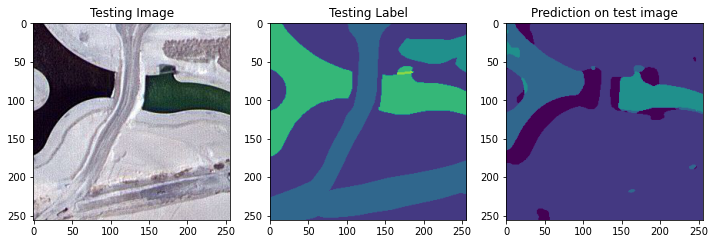

1/1 [==============================] - 0s 397ms/step


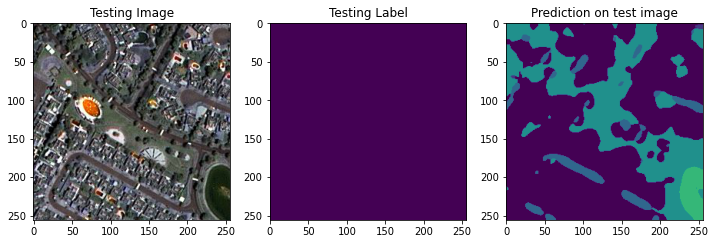

1/1 [==============================] - 0s 399ms/step


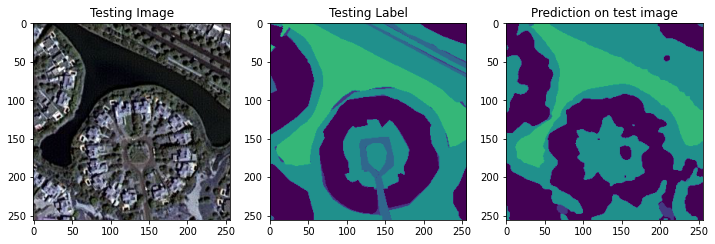

1/1 [==============================] - 0s 435ms/step


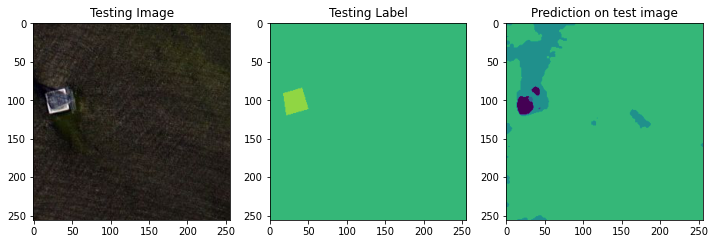

1/1 [==============================] - 0s 393ms/step


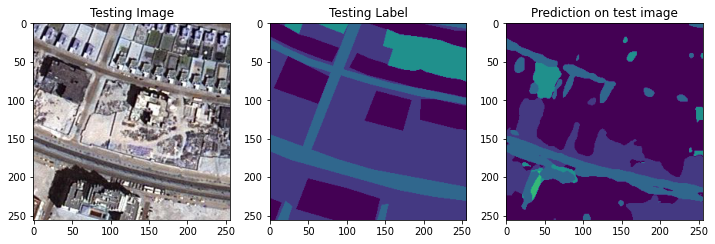

1/1 [==============================] - 0s 397ms/step


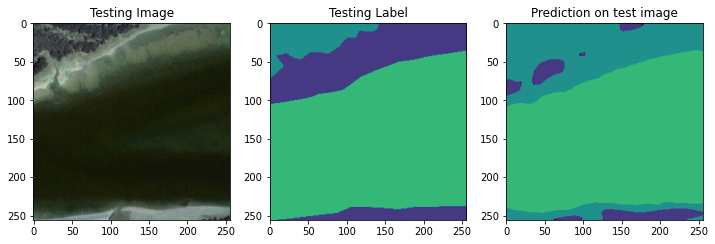

1/1 [==============================] - 0s 399ms/step


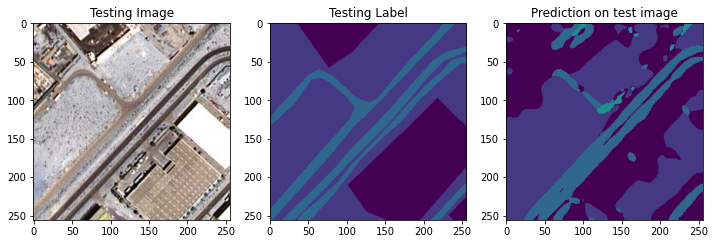

1/1 [==============================] - 0s 398ms/step


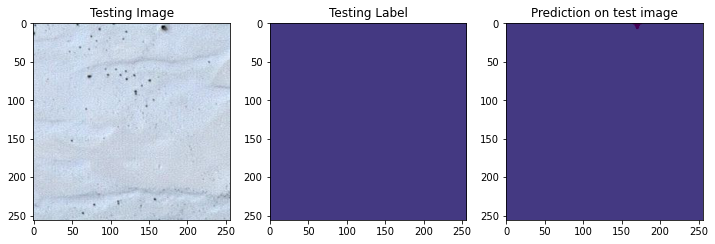

1/1 [==============================] - 0s 393ms/step


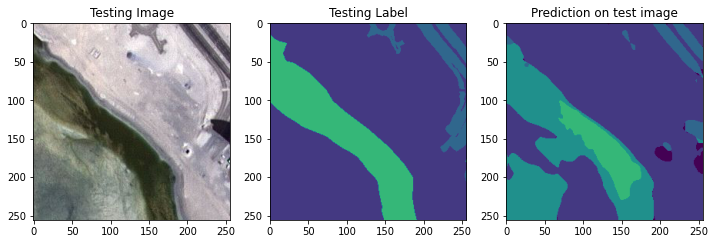

In [ ]:
num_samples = 10
test_img_numbers = random.sample(range(X_test.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()